In [1]:
import datetime
from IPython.display import display



from typing import List
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

from datetime import datetime
import requests
import mlflow
import pickle
from hyperopt import hp, STATUS_OK, Trials, pyll,fmin,tpe
import xgboost as xgb





import os

In [2]:
mlflow_experiment_name = "chicago-taxi-experiment"
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment(mlflow_experiment_name)

<Experiment: artifact_location='/home/arundac23/mlops-2023-project/experiment_tracking/mlruns/1', creation_time=1690668027362, experiment_id='1', last_update_time=1690668027362, lifecycle_stage='active', name='chicago-taxi-experiment', tags={}>

In [3]:
# def create_monthly_data_from_url(url, output_folder, months=[1, 2, 3]):
#     # Read the data from the URL into a pandas DataFrame
#     df = pd.read_csv(url)

#     # Convert the 'Trip Start Timestamp' column to datetime type
#     df['Trip Start Timestamp'] = pd.to_datetime(df['Trip Start Timestamp'])

#     # Filter the dataset to split the dataset into monthly data
#     filtered_df = df[df['Trip Start Timestamp'].dt.month.isin(months)]

#     # Create a output directory
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)

#     # Group the filtered DataFrame by month and year
#     grouped = filtered_df.groupby([filtered_df['Trip Start Timestamp'].dt.year, filtered_df['Trip Start Timestamp'].dt.month])

#     # Iterate through each group (month and year)
#     for (year, month), group_df in grouped:
#         # Create a filename for the monthly CSV file
#         filename = f"{output_folder}/chicago_taxi_data_{year}-{month:02}.csv"

#         # Save the group DataFrame to the CSV file
#         group_df.to_csv(filename, index=False)


In [4]:
# data_url = 'https://data.cityofchicago.org/api/views/e55j-2ewb/rows.csv?accessType=DOWNLOAD'  # Replace with the actual URL link
# output_folder = 'data/'
# months_to_save = [1, 2, 3]  # January, February, and March
# create_monthly_data_from_url(data_url, output_folder, months=months_to_save)

In [5]:
import pandas as pd

def convert_csv_to_parquet(csv_file_path, parquet_file_path):
    try:
        df = pd.read_csv(csv_file_path, low_memory=False)
        df.columns = df.columns.str.lower().str.replace(' ', '_')
        
        col_to_rmv_comma = ['trip_seconds', 'fare', 'tolls', 'extras', 'trip_total']
        for col in col_to_rmv_comma:
            df[col] = df[col].apply(lambda x: str(x).replace(',', ''))

        datatypes = {
            'trip_seconds': float,
            'fare': float,
            'pickup_community_area': str,
            'dropoff_community_area': str,
            'tolls': float,
            'extras': float,
            'trip_total': float
        }
        
        df = df.astype(datatypes)
        df['trip_start_timestamp'] = pd.to_datetime(df['trip_start_timestamp'])
        df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])

        # Save the DataFrame as a Parquet file
        df.to_parquet(parquet_file_path, index=False)

        print(f"CSV file '{csv_file_path}' successfully converted to Parquet: '{parquet_file_path}'")

    except FileNotFoundError:
        print(f"Error: CSV file not found at '{csv_file_path}'.")

    except Exception as e:
        print(f"An error occurred while converting CSV to Parquet: {e}")



In [6]:
# TRAIN DATASET:
Train_csv_file_path = 'data/chicago_taxi_data_2023-01.csv'  # Replace with the actual path to your CSV file
Train_parquet_file_path = 'data/chicago_taxi_train_dataset_2023-01.parquet'  # Replace with the desired Parquet file path
convert_csv_to_parquet(Train_csv_file_path, Train_parquet_file_path)

/tmp/ipykernel_22087/3805700532.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])


CSV file 'data/chicago_taxi_data_2023-01.csv' successfully converted to Parquet: 'data/chicago_taxi_train_dataset_2023-01.parquet'


In [7]:
# VALIDATION DATASET:
Val_csv_file_path = 'data/chicago_taxi_data_2023-02.csv'  
Val_parquet_file_path = 'data/chicago_taxi_Val_dataset_2023-02.parquet' 
convert_csv_to_parquet(Val_csv_file_path, Val_parquet_file_path)

/tmp/ipykernel_22087/3805700532.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])


CSV file 'data/chicago_taxi_data_2023-02.csv' successfully converted to Parquet: 'data/chicago_taxi_Val_dataset_2023-02.parquet'


In [8]:
# TEST DATASET:
Test_csv_file_path = 'data/chicago_taxi_data_2023-03.csv'  # Replace with the actual path to your CSV file
Test_parquet_file_path = 'data/chicago_taxi_test_dataset_2023-03.parquet'  # Replace with the desired Parquet file path
convert_csv_to_parquet(Test_csv_file_path, Test_parquet_file_path)

/tmp/ipykernel_22087/3805700532.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['trip_end_timestamp'] = pd.to_datetime(df['trip_end_timestamp'])


CSV file 'data/chicago_taxi_data_2023-03.csv' successfully converted to Parquet: 'data/chicago_taxi_test_dataset_2023-03.parquet'


In [9]:
df_train_r = pd.read_parquet(Train_parquet_file_path)
df_val_r = pd.read_parquet(Val_parquet_file_path)
df_test_r = pd.read_parquet(Test_parquet_file_path)

In [10]:
df_train_r.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414478 entries, 0 to 414477
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   trip_id                     414478 non-null  object        
 1   taxi_id                     414457 non-null  object        
 2   trip_start_timestamp        414478 non-null  datetime64[ns]
 3   trip_end_timestamp          414461 non-null  datetime64[ns]
 4   trip_seconds                414378 non-null  float64       
 5   trip_miles                  414478 non-null  float64       
 6   pickup_census_tract         136206 non-null  float64       
 7   dropoff_census_tract        135485 non-null  float64       
 8   pickup_community_area       414478 non-null  object        
 9   dropoff_community_area      414478 non-null  object        
 10  fare                        414073 non-null  float64       
 11  tips                        414073 non-

In [11]:
def analyse_dataframe(df: pd.DataFrame, target:str =None, verbose=False):
    
    print(f'Analysing dataset...')
    print(f'Dataset shape: {df.shape}')
    print(f'Dataset info:\n{df.info()}')
    
    df.head().T
    
    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
    numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)
    
    for column in df.columns:
        print('\nColumn Name:' + column)
        if column in categorical_columns:
            print('Itz a categorical type')
        else:
            print('Itz a numerical type')
        nuniques = df[column].nunique()
        if nuniques < 50:
            print(column, df[column].unique())
        else:
            print(f'Number of uniques values is {nuniques}')
        
        print(f'Number of nulls: {df[column].isnull().sum()}')
    
    sns.displot(df[target])
    
    print(f'\ndescription of target variable {target}:')
    print(df[target].describe(percentiles=[0.01, 0.05, 0.1, 0.2, 0.75, 0.95, 0.98, 0.99]))
    print(f'% of trips within 1-60 min: {((df[target] >= 60) & (df[target]<=60*60)).mean()}')
    
    return numerical_columns, categorical_columns

Analysing dataset...
Dataset shape: (414478, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414478 entries, 0 to 414477
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   trip_id                     414478 non-null  object        
 1   taxi_id                     414457 non-null  object        
 2   trip_start_timestamp        414478 non-null  datetime64[ns]
 3   trip_end_timestamp          414461 non-null  datetime64[ns]
 4   trip_seconds                414378 non-null  float64       
 5   trip_miles                  414478 non-null  float64       
 6   pickup_census_tract         136206 non-null  float64       
 7   dropoff_census_tract        135485 non-null  float64       
 8   pickup_community_area       414478 non-null  object        
 9   dropoff_community_area      414478 non-null  object        
 10  fare                        414073 non-null  float64   

/home/arundac23/enter/envs/mlops-project-2023/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)



description of target variable trip_seconds:
count    414378.000000
mean       1099.599006
std        1791.298925
min           0.000000
1%            0.000000
5%           60.000000
10%         232.000000
20%         360.000000
50%         832.000000
75%        1500.000000
95%        2601.000000
98%        3240.000000
99%        3838.000000
max       86340.000000
Name: trip_seconds, dtype: float64
% of trips within 1-60 min: 0.9403345895318931


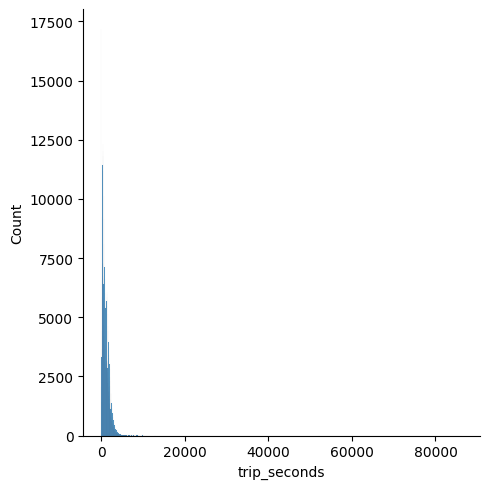

In [12]:
numerical_columns, categorical_columns = analyse_dataframe(df_train_r, target='trip_seconds')

In [13]:
import pandas as pd
from typing import List

def preprocess_data(df: pd.DataFrame, categorical_features: List[str], numerical_features: List[str], verbose: bool = False):

    df = df[df.trip_seconds.notnull()]
    df = df[df.trip_start_timestamp.notnull()]
    
    df = df[(df['trip_seconds'] > 60) & (df['trip_seconds'] < 3600)]

    # Create the 'duration' column in minutes as the target variable
    df['duration'] = df['trip_seconds'] / 60

    # Preprocess categorical features
    for column in categorical_features:
        if verbose:
            print(f"\nFilling {round(df[column].isna().mean() * 100, 2)}% of nans with -1 in column: {column}")
        df[column].fillna(-1, inplace=True)
        df[column] = df[column].astype('str')
        df[column] = df[column].str.lower().str.replace(' ', '_')

    # Select only the relevant columns
    target = ['duration']
    selected_columns = categorical_features + numerical_features + target
    df = df[selected_columns]

    if verbose:
        print(f"\nfinal shape: {df.shape}")
        print(f"\nfinal types:\n{df.dtypes}")
        print(f"\ncategorical_features: {categorical_features}")
        print(f"\nnumerical_features: {numerical_features}")
        print(f"\ntarget: {target}")

    return df[categorical_features + numerical_features], df[target]


In [14]:
df_test, y_test = preprocess_data(
    df_test_r,
    categorical_features=['pickup_community_area','dropoff_community_area'],
    numerical_features=[],
    verbose=True
)


Filling 0.0% of nans with -1 in column: pickup_community_area

Filling 0.0% of nans with -1 in column: dropoff_community_area

final shape: (542815, 3)

final types:
pickup_community_area      object
dropoff_community_area     object
duration                  float64
dtype: object

categorical_features: ['pickup_community_area', 'dropoff_community_area']

numerical_features: []

target: ['duration']


In [15]:
df_val, y_val = preprocess_data(
    df_val_r,
    categorical_features=['pickup_community_area','dropoff_community_area'],
    numerical_features=[],
    verbose=True
)


Filling 0.0% of nans with -1 in column: pickup_community_area

Filling 0.0% of nans with -1 in column: dropoff_community_area

final shape: (417382, 3)

final types:
pickup_community_area      object
dropoff_community_area     object
duration                  float64
dtype: object

categorical_features: ['pickup_community_area', 'dropoff_community_area']

numerical_features: []

target: ['duration']


In [16]:
df_train, y_train = preprocess_data(
    df_train_r,
    categorical_features=['pickup_community_area','dropoff_community_area'],
    numerical_features=[],
    verbose=True
)


Filling 0.0% of nans with -1 in column: pickup_community_area

Filling 0.0% of nans with -1 in column: dropoff_community_area

final shape: (387579, 3)

final types:
pickup_community_area      object
dropoff_community_area     object
duration                  float64
dtype: object

categorical_features: ['pickup_community_area', 'dropoff_community_area']

numerical_features: []

target: ['duration']


In [17]:
def prepare_dictionaries(df:pd.DataFrame, categorical_features:List[str], numerical_features:List[str]):
    dicts = df[categorical_features + numerical_features].to_dict(orient='records')
    return dicts

In [18]:
train_dict = prepare_dictionaries(
    df_train,
    categorical_features=['pickup_community_area','dropoff_community_area'],
    numerical_features=[]
)
val_dict = prepare_dictionaries(
    df_val,
    categorical_features=['pickup_community_area','dropoff_community_area'],
    numerical_features=[]
)
test_dict = prepare_dictionaries(
    df_test,
    categorical_features=['pickup_community_area','dropoff_community_area'],
    numerical_features=[]
)

In [19]:
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

In [20]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)

In [21]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

print(f'Train RMSE: {mean_squared_error(y_train, y_pred, squared=False)}')

Train RMSE: 9.591189039817566


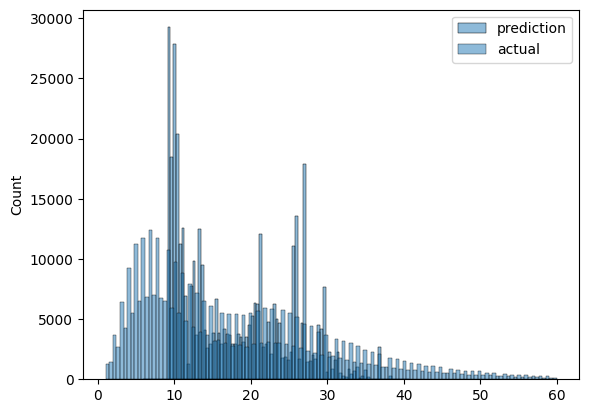

In [22]:
sns.histplot(y_pred, color='red',label='prediction')
sns.histplot(y_train, color='green',label='actual')

plt.legend();

 ### Evaluating the model

In [23]:
y_pred = lr.predict(X_val)

In [24]:
print(f'Val RMSE: {mean_squared_error(y_val, y_pred, squared=False)}')

Val RMSE: 9.810990354874242


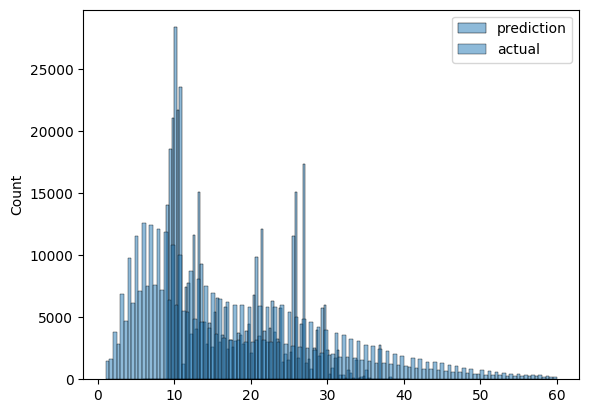

In [25]:
sns.histplot(y_pred, label='prediction')
sns.histplot(y_val, label='actual')

plt.legend();

In [26]:
# with open('models/lin_reg.bin', 'wb') as f_out:
#     pickle.dump((dv, lr), f_out)

In [27]:
# with mlflow.start_run():
#     mlflow.set_tag('developer', 'Arun')
#     mlflow.set_tag('project', 'chicago taxi prediction')
#     mlflow.log_param('train-data_path', Train_parquet_file_path)
#     mlflow.log_param('Validation-data_path', Val_parquet_file_path)

#     alpha = 0.001
#     mlflow.log_param('alpha', alpha)
#     las = Lasso(alpha)
#     las.fit(X_train, y_train)

#     y_pred = las.predict(X_val)
    
#     rmse_las = mean_squared_error(y_val, y_pred, squared=False)

#     print(f'Val RMSE of lasso model: {rmse_las}')
#     mlflow.log_metric('Val RMSE of lasso model', rmse_las)
#     mlflow.log_artifact(local_path='models/lasso_model.bin')

In [28]:
# with open('models/lasso_model.bin', 'wb') as f_out:
#     pickle.dump((dv, las),f_out)

In [29]:
linear_space = {}

lasso_space = {
    'alpha': hp.loguniform('alpha', -6, 2)
}

ridge_space = {
    'alpha': hp.loguniform('alpha', -6, 3)
}

rf_space = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 150]),
    'max_depth': hp.choice('max_depth', [None, 10, 20]),
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4])
}

gb_space = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 150]),
    'learning_rate': hp.choice('learning_rate', [0.01, 0.1, 0.2]),
    'max_depth': hp.choice('max_depth', [3, 5, 7]),
    'subsample': hp.choice('subsample', [0.6, 0.8, 1.0])
}

et_space = {
    'n_estimators': hp.choice('n_estimators', [50, 100, 150, 200, 250]),
    'max_depth': hp.choice('max_depth', [None, 5, 10, 15, 20]),
    'min_samples_split': hp.choice('min_samples_split', [2, 5, 10, 20]),
    'min_samples_leaf': hp.choice('min_samples_leaf', [1, 2, 4, 8])
}


def train_evaluate(params, model_name):
    if model_name == 'LinearRegression':
        model = LinearRegression()
    elif model_name == 'Lasso':
        model = Lasso(**params)
    elif model_name == 'Ridge':
        model = Ridge(**params)
    elif model_name == 'RandomForest':
        model = RandomForestRegressor(random_state=42)
    elif model_name == 'GradientBoosting':
        model = GradientBoostingRegressor(**params, random_state=42)
    elif model_name == 'ExtraTrees':
        model = ExtraTreesRegressor(random_state=42)
    else:
        raise ValueError(f"Unknown model: {model_name}")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    rmse_test = mean_squared_error(y_test, model.predict(X_test), squared=False)
    return {'loss': rmse, 'status': STATUS_OK, 'rmse_test': rmse_test}

models = [
    ('LinearRegression', linear_space),
    ('Lasso', lasso_space),
    ('Ridge', ridge_space),
    ('RandomForest', rf_space),
    ('GradientBoosting', gb_space),
    ('ExtraTrees', et_space)
]

for model, space in models:
    with mlflow.start_run(run_name=model):
        trials = Trials()
        hyperopt_space = pyll.as_apply(space)
        best_params = pyll.stochastic.sample(hyperopt_space)
        
        # Get the best model with the best hyperparameters
        best_model_params = {k: best_params[k] for k in space}
        mlflow.log_params(best_model_params)
        
        # Log additional metrics and tags
        best_model = train_evaluate(best_model_params, model)
        mlflow.set_tag('developer', 'Arun')
        mlflow.set_tag('project', 'chicago taxi prediction')
        mlflow.log_param('train-data_path', Train_parquet_file_path)
        mlflow.log_param('Validation-data_path', Val_parquet_file_path)
        mlflow.log_metric('val_rmse', best_model['loss'])
        mlflow.log_metric('test_rmse', best_model['rmse_test'])
        mlflow.set_tag("model_name", model)
        with open('models/preprocessor.b','wb') as f_out:
            pickle.dump(dv,f_out)
        mlflow.log_artifact('models/preprocessor.b',artifact_path='preprocessor')
        mlflow.sklearn.log_model(model, artifact_path="models")

        print(f'Best {model} Hyperparameters: {best_model_params}')
        print(f'Best {model} RMSE: {best_model["loss"]}')
        print(f'Best {model} RMSE on test data: {best_model["rmse_test"]}')


2023/08/10 19:48:33 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Best LinearRegression Hyperparameters: {}
Best LinearRegression RMSE: 9.810990354874242
Best LinearRegression RMSE on test data: 10.51833160070743


2023/08/10 19:48:37 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
/home/arundac23/enter/envs/mlops-project-2023/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/arundac23/enter/envs/mlops-project-2023/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Best Lasso Hyperparameters: {'alpha': 0.0892614913758354}
Best Lasso RMSE: 10.20308432341211
Best Lasso RMSE on test data: 10.925903745146648


2023/08/10 19:48:38 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
/home/arundac23/enter/envs/mlops-project-2023/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/arundac23/enter/envs/mlops-project-2023/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/home/arundac23/enter/envs/mlops-project-2023/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed whe

Best Ridge Hyperparameters: {'alpha': 0.40839218023764756}
Best Ridge RMSE: 9.810967665093086
Best Ridge RMSE on test data: 10.518324371337725


2023/08/10 19:51:35 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
/home/arundac23/enter/envs/mlops-project-2023/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/arundac23/enter/envs/mlops-project-2023/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/home/arundac23/enter/envs/mlops-project-2023/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning: A column-vector y was pas

Best RandomForest Hyperparameters: {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 4}
Best RandomForest RMSE: 8.11854983176106
Best RandomForest RMSE on test data: 8.658390359289022


2023/08/10 19:52:19 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
/home/arundac23/enter/envs/mlops-project-2023/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/arundac23/enter/envs/mlops-project-2023/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
/home/arundac23/enter/envs/mlops-project-2023/lib/python3.9/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed whe

Best GradientBoosting Hyperparameters: {'n_estimators': 150, 'learning_rate': 0.01, 'max_depth': 7, 'subsample': 1.0}
Best GradientBoosting RMSE: 9.304180936291587
Best GradientBoosting RMSE on test data: 9.882112107585105


2023/08/10 19:54:58 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


Best ExtraTrees Hyperparameters: {'n_estimators': 250, 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 8}
Best ExtraTrees RMSE: 8.127108005447115
Best ExtraTrees RMSE on test data: 8.666156803119927


/home/arundac23/enter/envs/mlops-project-2023/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/arundac23/enter/envs/mlops-project-2023/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [30]:
from hyperopt.pyll import scope
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)
test = xgb.DMatrix(X_test)

def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("val_rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [31]:
# search_space = {
#     'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
#     'learning_rate': hp.loguniform('learning_rate', -3, 0),
#     'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
#     'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
#     'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
#     'objective': 'reg:linear',
#     'seed': 42
# }

# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=5,
#     trials=Trials()
# )

In [32]:
mlflow.xgboost.autolog(disable=True)

In [33]:
with mlflow.start_run(run_name='xgboost'):
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)
    test = xgb.DMatrix(X_test,label=y_test)
    Best_Params = {
    'learning_rate':	0.5458691870793922,
    'max_depth':	38,
    'min_child_weight':	7.968333201830882,
    'objective':	'reg:linear',
    'reg_alpha':	0.19154033738324955,
    'reg_lambda':	0.032825863134369984,
    'seed':	42
    }
mlflow.log_params(Best_Params)
booster = xgb.train(
        params=Best_Params,
        dtrain=train,
        num_boost_round=200,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
)
y_pred = booster.predict(valid)
y_pred_test = booster.predict(test)
rmse = mean_squared_error(y_val, y_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mlflow.set_tag('developer', 'Arun')
mlflow.set_tag('project', 'chicago taxi prediction')
mlflow.log_param('train-data_path', Train_parquet_file_path)
mlflow.log_param('Validation-data_path', Val_parquet_file_path)
mlflow.log_param('Test-data_path', Test_parquet_file_path)
mlflow.log_metric("val_rmse", rmse)
mlflow.log_metric("test_rmse", rmse_test)

with open('models/preprocessor.b','wb') as f_out:
    pickle.dump(dv,f_out)
mlflow.log_artifact('models/preprocessor.b',artifact_path='preprocessor')
mlflow.xgboost.log_model(booster, artifact_path="models")
mlflow.end_run()

[19:54:59] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:12.42078
[1]	validation-rmse:9.37398
[2]	validation-rmse:8.50815
[3]	validation-rmse:8.26735
[4]	validation-rmse:8.19086
[5]	validation-rmse:8.16348
[6]	validation-rmse:8.15063
[7]	validation-rmse:8.13162
[8]	validation-rmse:8.12527
[9]	validation-rmse:8.11957
[10]	validation-rmse:8.11854
[11]	validation-rmse:8.11691
[12]	validation-rmse:8.11642
[13]	validation-rmse:8.11536
[14]	validation-rmse:8.11530
[15]	validation-rmse:8.11465
[16]	validation-rmse:8.11418
[17]	validation-rmse:8.11355
[18]	validation-rmse:8.11351
[19]	validation-rmse:8.11322
[20]	validation-rmse:8.11337
[21]	validation-rmse:8.11300
[22]	validation-rmse:8.11264
[23]	validation-rmse:8.11217
[24]	validation-rmse:8.11222
[25]	validation-rmse:8.11206
[26]	validation-rmse:8.11199
[27]	validation-rmse:8.11185
[28]	validation-rmse:8.11189
[29]	validation-rmse:8.11197
[30]	validation-rmse

/home/arundac23/enter/envs/mlops-project-2023/lib/python3.9/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/arundac23/enter/envs/mlops-project-2023/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [34]:
from mlflow.tracking import MlflowClient
import mlflow

ML_FLOW_TRACKING_URI = "sqlite:///mlflow.db"
client = MlflowClient(tracking_uri=ML_FLOW_TRACKING_URI)

In [35]:
from mlflow.entities import ViewType
runs = client.search_runs(
    experiment_ids='1',
    filter_string='metrics.test_rmse < 9',
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.test_rmse ASC"]
)

In [40]:
for run in runs:
    print(f"run id: {run.info.run_id}, \nVal_rmse: {run.data.metrics['val_rmse']:.3f} \nTest rmse: {run.data.metrics['test_rmse']:.3f}")

run id: aea032c047344461a62915b096cca1ee, 
Val_rmse: 8.106 
Test rmse: 8.645
run id: 39a811d73b284f92a656d103242c70e4, 
Val_rmse: 8.119 
Test rmse: 8.658
run id: 4033a44dd181406b8dd876faa49a3170, 
Val_rmse: 8.127 
Test rmse: 8.666


In [41]:
mlflow.set_tracking_uri(ML_FLOW_TRACKING_URI)

In [42]:
run_ids = ["aea032c047344461a62915b096cca1ee","39a811d73b284f92a656d103242c70e4","4033a44dd181406b8dd876faa49a3170"]
for run_id in run_ids:
    model_uri = f"runs:/{run_id}/model"
    mlflow.register_model(model_uri=model_uri, name="chicago-taxi-prediction-model")

Registered model 'chicago-taxi-prediction-model' already exists. Creating a new version of this model...
2023/08/10 23:41:26 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: chicago-taxi-prediction-model, version 4
Created version '4' of model 'chicago-taxi-prediction-model'.
Registered model 'chicago-taxi-prediction-model' already exists. Creating a new version of this model...
2023/08/10 23:41:26 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: chicago-taxi-prediction-model, version 5
Created version '5' of model 'chicago-taxi-prediction-model'.
Registered model 'chicago-taxi-prediction-model' already exists. Creating a new version of this model...
2023/08/10 23:41:26 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: chicago-taxi-prediction-model, version 6
Created version

In [43]:
model_name = 'chicago-taxi-prediction-model'
latest_version = client.get_latest_versions(name=model_name)
for version in latest_version:
    print(f"version: {version.version}, status: {version.current_stage}")

version: 1, status: Staging
version: 6, status: None


In [44]:
client.transition_model_version_stage(
    name=model_name,
    version=1,
    stage="staging",
    archive_existing_versions=False
)

<ModelVersion: aliases=[], creation_timestamp=1691722895624, current_stage='Staging', description=('Moved version 1 is selected for staging for this '
 'chicago-taxi-prediction-model at 2023-08-10 23:29:19'), last_updated_timestamp=1691725350317, name='chicago-taxi-prediction-model', run_id='aea032c047344461a62915b096cca1ee', run_link=None, source='/home/arundac23/mlops-2023-project/experiment_tracking/mlruns/1/aea032c047344461a62915b096cca1ee/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

### STAGING THE BEST MODEL

In [45]:
from datetime import datetime
date = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
client.update_model_version(
    name=model_name,
    version=1,
    description=f"Moved version 1 is selected for staging for this {model_name} at {date}",
)

<ModelVersion: aliases=[], creation_timestamp=1691722895624, current_stage='Staging', description=('Moved version 1 is selected for staging for this '
 'chicago-taxi-prediction-model at 2023-08-10 23:42:43'), last_updated_timestamp=1691725363011, name='chicago-taxi-prediction-model', run_id='aea032c047344461a62915b096cca1ee', run_link=None, source='/home/arundac23/mlops-2023-project/experiment_tracking/mlruns/1/aea032c047344461a62915b096cca1ee/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>